In [1]:
import json
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
import random
import torchvision
from Loader_17 import normalize
import torchvision.tv_tensors
from preprocess_utensils import get_boundary_points, uniform_sample_points
from einops import repeat
from tqdm import tqdm

In [2]:
meta_json_path = "youtube/train/meta.json"
with open(meta_json_path, "r") as f:
    meta = json.load(f)
meta.keys()

dict_keys(['videos'])

In [3]:
video_names = list(meta["videos"].keys())
video_names[0]

'003234408d'

In [4]:
video_meta = meta["videos"][video_names[111]]["objects"]
video_meta.keys(), video_meta["1"].keys(), video_meta["1"]["frames"]

(dict_keys(['1', '2', '3', '4']),
 dict_keys(['category', 'frames']),
 ['00000',
  '00005',
  '00010',
  '00015',
  '00020',
  '00025',
  '00030',
  '00035',
  '00040',
  '00045',
  '00050',
  '00055',
  '00060',
  '00065',
  '00070',
  '00075',
  '00080',
  '00085',
  '00090',
  '00095',
  '00100',
  '00105',
  '00110',
  '00115',
  '00120',
  '00125',
  '00130',
  '00135',
  '00140',
  '00145',
  '00150',
  '00155',
  '00160',
  '00165',
  '00170',
  '00175'])

36


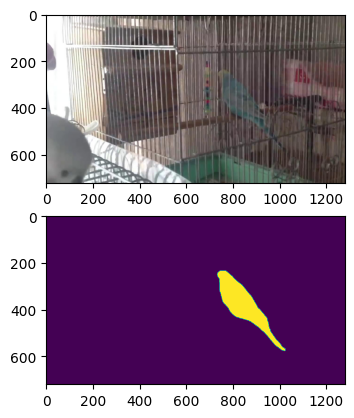

In [5]:
class FramesMeta:
    def __init__(
        self,
        frame_names: list[str],
        video_name: str,
        object_idx: int,
        is_train: bool,
    ) -> None:
        self.frame_names = frame_names
        self.video_name = video_name
        self.is_train = is_train
        self.object_idx = object_idx

    def __len__(self) -> int:
        return len(self.frame_names)

    def __getitem__(self, frame_idx: int) -> tuple[np.array, np.array]:
        frame_prefix = f"youtube/{'train' if self.is_train else 'valid'}"
        img_path = (
            Path(frame_prefix)
            / "JPEGImages"
            / self.video_name
            / f"{self.frame_names[frame_idx]}.jpg"
        )
        annotations_path = (
            Path(frame_prefix)
            / "Annotations"
            / self.video_name
            / f"{self.frame_names[frame_idx]}.png"
        )
        img = Image.open(img_path)
        mask = Image.open(annotations_path)
        img = np.array(img)
        mask = np.array(mask)
        mask = mask == self.object_idx + 1
        mask = mask.astype(np.uint8)
        return img, mask


video_idx = 1222
object_idx = 0
frame_idx = 0
frame_mata = FramesMeta(
    meta["videos"][video_names[video_idx]]["objects"][f"{object_idx + 1}"]["frames"],
    video_names[video_idx],
    object_idx,
    is_train=True,
)
print(len(frame_mata))
# load and show image and annotation
plt.subplot(2, 1, 1)
plt.imshow(frame_mata[frame_idx][0])
plt.subplot(2, 1, 2)
plt.imshow(frame_mata[frame_idx][1])
plt.show()

1
29
uint8 uint8
(720, 1280, 3) (720, 1280)


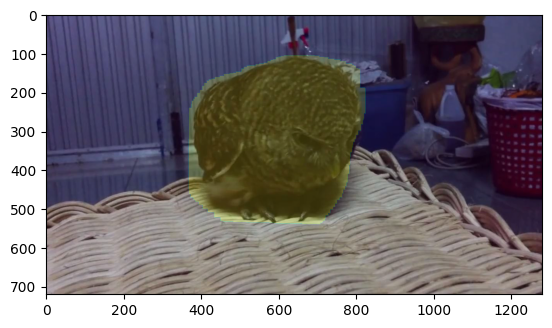

In [6]:
class VideoMeta:
    def __init__(
        self,
        video_meta: dict,
        video_name: str,
        is_train: bool,
    ) -> None:
        self.video_dict = video_meta
        self.video_name = video_name
        self.object_names = list(video_meta.keys())
        self.is_train = is_train

    def __len__(self) -> int:
        return len(self.object_names)

    def __getitem__(self, object_idx: int) -> FramesMeta:
        return FramesMeta(
            self.video_dict[self.object_names[object_idx]]["frames"],
            self.video_name,
            object_idx,
            self.is_train,
        )

video_idx = 1111
object_idx = 0
frame_idx = 0
video_meta = VideoMeta(
    meta["videos"][video_names[video_idx]]["objects"],
    video_names[video_idx],
    is_train=True,
)
print(len(video_meta))
# load and show image and annotation
frame_mata = video_meta[object_idx]
print(len(frame_mata))
plt.imshow(frame_mata[frame_idx][0])
plt.imshow(frame_mata[frame_idx][1], alpha=0.2)
print(frame_mata[frame_idx][0].dtype, frame_mata[frame_idx][1].dtype)
print(frame_mata[frame_idx][0].shape, frame_mata[frame_idx][1].shape)
plt.show()

3471
1
36


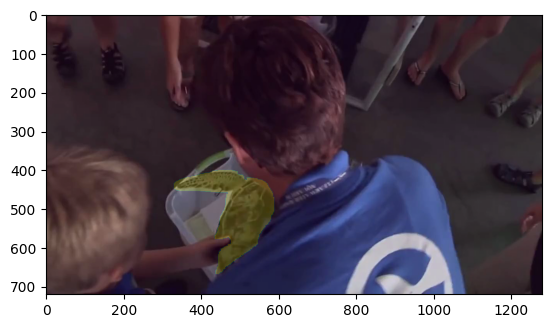

In [7]:
class YoutubeMeta:
    def __init__(self, is_train: bool) -> None:
        self.is_train = is_train
        if is_train:
            meta_json_path = "youtube/train/meta.json"
        else:
            meta_json_path = "youtube/valid/meta.json"
        with open(meta_json_path, "r") as f:
            self.meta = json.load(f)
        self.video_names = list(self.meta["videos"].keys())

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx) -> VideoMeta:
        video_name = self.video_names[idx]
        video_meta = self.meta["videos"][video_name]["objects"]
        return VideoMeta(video_meta, video_name, self.is_train)
    
youtube_meta = YoutubeMeta(is_train=True)
print(len(youtube_meta))
video_idx = 790
object_idx = 0
frame_idx = 0
video_meta = youtube_meta[video_idx]
print(len(video_meta))
# load and show image and annotation
frame_mata = video_meta[object_idx]
print(len(frame_mata))
img, mask = frame_mata[frame_idx]
plt.imshow(img)
plt.imshow(mask, alpha=0.2)
plt.show()

<class 'torchvision.tv_tensors._image.Image'> <class 'torchvision.tv_tensors._mask.Mask'>


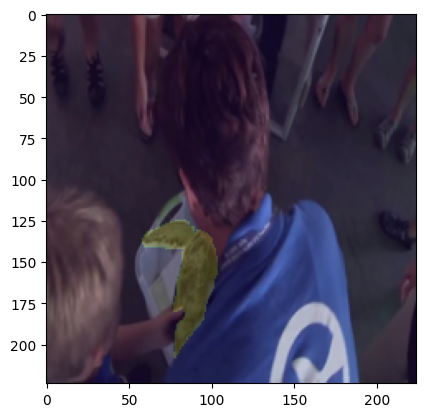

In [8]:
img_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
mask_transform = v2.Compose(
    [
        v2.Resize((224, 224), interpolation="nearest"),
    ]
)
resized_img = img_transform(img)
resized_mask = mask_transform(torchvision.tv_tensors.Mask(mask))
print(type(resized_img), type(resized_mask))
plt.imshow(normalize(resized_img.permute(1, 2, 0)))
plt.imshow(resized_mask, alpha=0.2)
plt.show()

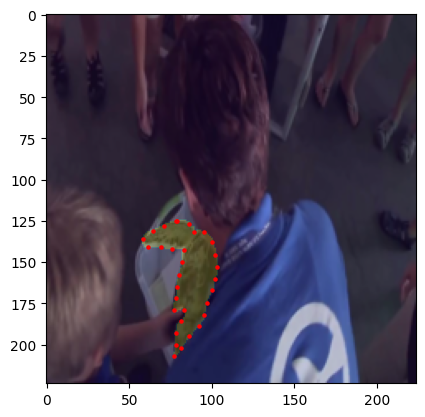

In [9]:
def _get_boundary_points(mask: torch.Tensor, point_num: int) -> torch.Tensor:
    boundary = get_boundary_points(mask.numpy())
    boundary = uniform_sample_points(boundary, point_num)
    boundary = torch.tensor(boundary, dtype=torch.float32)
    return boundary
point = _get_boundary_points(resized_mask, 32)
plt.imshow(normalize(resized_img.permute(1, 2, 0)))
plt.scatter(point[:, 0], point[:, 1], c="r", s=5)
plt.imshow(resized_mask, alpha=0.2)
plt.show()

In [10]:
class YoutubeDataset(Dataset):
    def __init__(
        self,
        is_train: bool,
        point_num: int,
        frame_num: int,
        is_eval: bool,
    ) -> None:
        self.youtube_meta = YoutubeMeta(is_train)
        self.point_num = point_num
        self.frame_num = frame_num
        self.is_eval = is_eval
        self.img_transform = v2.Compose(
            [
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Resize((224, 224)),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        self.mask_transform = v2.Compose(
            [
                v2.Resize((224, 224), interpolation="nearest"),
            ]
        )

    def __len__(self) -> int:
        return len(self.youtube_meta)

    def __getitem__(self, idx) -> tuple[
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
    ]:
        video_meta = self.youtube_meta[idx]
        object_idx = random.randint(0, len(video_meta) - 1)
        fir_mask = video_meta[object_idx][0][1]
        count = 0
        while fir_mask.sum() == 0:
            if count > 5:
                # reselect the video_idx
                idx = random.randint(0, len(self.youtube_meta) - 1)
                video_meta = self.youtube_meta[idx]
            object_idx = random.randint(0, len(video_meta) - 1)
            fir_mask = video_meta[object_idx][0][1]
            # resample if the first frame has no mask
            count += 1
        total_frame_num = len(video_meta[object_idx])
        selected_frame_idxs = []
        if total_frame_num <= self.frame_num:
            selected_frame_idxs = list(range(total_frame_num))
        else:
            # uniformly sample frame_num frames, and the first frame is always included
            selected_frame_idxs.append(0)
            interval = (total_frame_num - 1) // (self.frame_num - 1)
            if self.is_eval:
                offset = 0
            else:
                offset_min = -(interval - 1)
                offset_max = (total_frame_num - 1) - (self.frame_num - 1) * interval
                offset = random.randint(offset_min, offset_max)
            for i in range(1, self.frame_num):
                selected_frame_idxs.append(interval * i + offset)
        img_list = []
        mask_list = []
        for idx in selected_frame_idxs:
            img, mask = video_meta[object_idx][idx]
            img = self.img_transform(img)
            mask = self.mask_transform(torchvision.tv_tensors.Mask(mask))
            img_list.append(img)
            mask_list.append(mask)

        def _get_boundary_points(mask: torch.Tensor, point_num: int) -> torch.Tensor:
            boundary = get_boundary_points(mask.numpy())
            boundary = uniform_sample_points(boundary, point_num)
            boundary = torch.tensor(boundary, dtype=torch.float32)
            return boundary

        fir_mask = mask_list[0]
        fir_point = _get_boundary_points(fir_mask, self.point_num)
        points = repeat(fir_point, "n p -> f n p", f=len(mask_list))
        imgs = torch.stack(img_list)
        masks = torch.stack(mask_list)
        return imgs, masks, points

In [11]:
youtube_dataset = YoutubeDataset(is_train=True, point_num=32, frame_num=10, is_eval=False)
youtube_loader = DataLoader(youtube_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
for i in tqdm(range(357 + 360, len(youtube_loader))):
    imgs, masks, points = youtube_dataset[i]
    pass

  0%|▎                                                                                                            | 8/2754 [00:02<13:02,  3.51it/s]


KeyboardInterrupt: 

In [13]:
val_dataset = YoutubeDataset(is_train=False, point_num=32, frame_num=10, is_eval=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

In [15]:
for imgs, masks, points in tqdm(val_loader):
    pass

  0%|                                                                                                                      | 0/507 [00:00<?, ?it/s]

  1%|█▎                                                                                                            | 6/507 [00:01<02:38,  3.16it/s]


KeyboardInterrupt: 

In [17]:
imgs.shape, masks.shape, points.shape

(torch.Size([1, 10, 3, 224, 224]),
 torch.Size([1, 10, 224, 224]),
 torch.Size([1, 10, 32, 2]))

In [24]:
len(youtube_dataset), len(val_dataset)

(3471, 507)

In [12]:
small_train_dataset = YoutubeDataset(is_train=True, point_num=32, frame_num=10, is_eval=False)
small_train_dataset = torch.utils.data.Subset(small_train_dataset, range(10))
small_train_loader = DataLoader(small_train_dataset, batch_size=1, shuffle=False, num_workers=0)

In [14]:
small_val_dataset = YoutubeDataset(is_train=False, point_num=32, frame_num=10, is_eval=True)
small_val_dataset = torch.utils.data.Subset(small_val_dataset, list(range(10)))
small_val_loader = DataLoader(small_val_dataset, batch_size=1, shuffle=False, num_workers=0)

In [15]:
from polygon import SoftPolygon, RasLoss
from cotracker import Cotracker, VideoLoss
from torch import optim

In [16]:
model = Cotracker(32).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [17]:
ras_loss = RasLoss().cuda()
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
video_loss = VideoLoss(ras_loss, gt_rasterizer).cuda()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
loss_dict = {}
iou_train_dict = {}
iou_val_dict = {}
best_val_iou = 0
epoch_num = 5

In [21]:
for e in range(epoch_num):
    total_loss = 0
    total_iou = 0
    model.train()
    for imgs, masks, points in tqdm(small_train_loader):
        optimizer.zero_grad()
        imgs = imgs.cuda()
        masks = masks.cuda()
        points = points.cuda()
        fir_points = points[:, 0]
        frame_num = masks.shape[1]
        init_points = repeat(fir_points, 'b h w -> b f h w', f=frame_num)
        pred_points = model(imgs, init_points)
        target_masks = masks[:, 1:]
        loss, iou = video_loss(pred_points, target_masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()
    loss_dict[e] = total_loss / len(small_train_loader)
    iou_train_dict[e] = total_iou / len(small_train_loader)
    print(f"Epoch {e}, Loss: {loss_dict[e]:.4f}, Train IoU: {iou_train_dict[e]:.4f}")
    # Eval the model
    if e % 1 == 0 or e == epoch_num - 1:
        total_iou = 0
        model.eval()
        with torch.no_grad():
            for imgs, masks, points in tqdm(small_val_loader):
            # for imgs, masks, points in small_train_loader:
                imgs = imgs.cuda()
                masks = masks.cuda()
                points = points.cuda()
                fir_points = points[:, 0]
                frame_num = masks.shape[1]
                init_points = repeat(fir_points, 'b h w -> b f h w', f=frame_num)
                pred_points = model(imgs, init_points)
                target_masks = masks[:, 1:]
                _, iou = video_loss(pred_points, target_masks)
                total_iou += iou.item()
        iou_val_dict[e] = total_iou / len(small_val_loader)
        # iou_val_dict[e] = total_iou / len(small_train_loader)

        print(f"Epoch {e}, Val IoU: {iou_val_dict[e]:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch 0, Loss: 0.4878, Train IoU: 0.4209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch 0, Val IoU: 0.3604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


Epoch 1, Loss: 0.5216, Train IoU: 0.3606


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


Epoch 1, Val IoU: 0.2636


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s]


Epoch 2, Loss: 0.6112, Train IoU: 0.3085


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


Epoch 2, Val IoU: 0.2327


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


Epoch 3, Loss: 0.5023, Train IoU: 0.3929


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:06<00:02,  1.11it/s]


KeyboardInterrupt: 